In [ ]:
# !jupyter labextension install @jupyterlab/toc

In [33]:
from operator import inv
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import random
import numpy as np
import numpy.random as rnd
import copy
from numpy.linalg import inv, norm
import numpy.linalg as linalg
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

PADDING_RATE = 1/5
METRIC_DISTANCE = 'Canberra'
# METRIC_DISTANCE = 'L2'

In [2]:
df_a2mm_smi700_cmg211 = pd.read_csv('df_a2mm_smi700_cmg211_merged_500k.csv', sep=';')

C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (22,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(443509, 2)


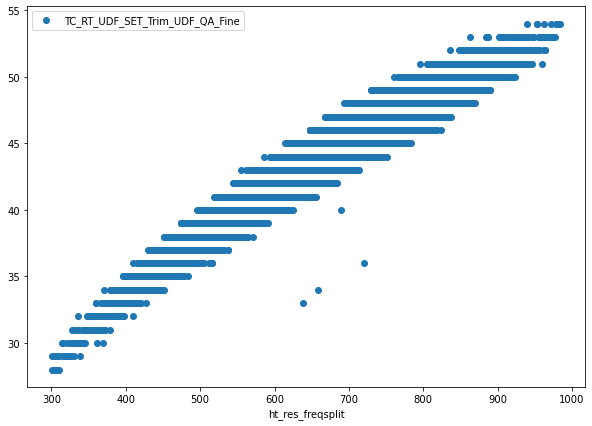

In [63]:
d = {'ht_res_freqsplit' :df_a2mm_smi700_cmg211['ht_res_freqsplit'][df_a2mm_smi700_cmg211['first_fail'].isnull()],
     'TC_RT_UDF_SET_Trim_UDF_QA_Fine' : df_a2mm_smi700_cmg211['TC_RT_UDF_SET_Trim_UDF_QA_Fine'][df_a2mm_smi700_cmg211['first_fail'].isnull()]}

df = pd.DataFrame(d)
df = df.dropna()
print(df.shape)
df.plot(figsize=(10,7), x='ht_res_freqsplit', y='TC_RT_UDF_SET_Trim_UDF_QA_Fine', style='o')

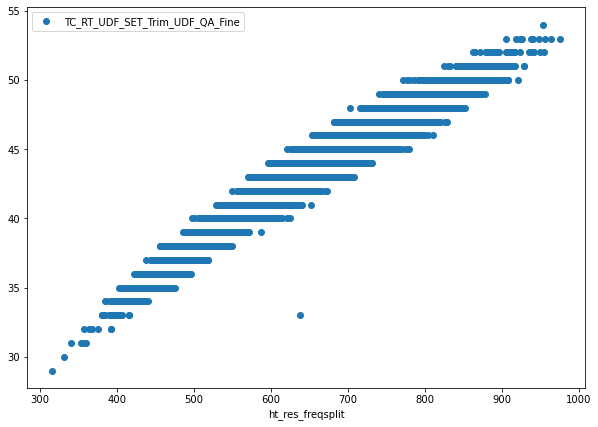

In [31]:
df_simple=df.sample(frac=0.1, replace=False)
df_simple.plot(figsize=(10,7), x='ht_res_freqsplit', y='TC_RT_UDF_SET_Trim_UDF_QA_Fine', style='o')

In [34]:
print(df.shape)

(451213, 2)


In [36]:
y = [i for i in range(df.shape[0])]
print(len(y))

451213


In [58]:
df['ht_res_freqsplit'].isnull().sum()

217

In [65]:

x1s = np.unique(df['ht_res_freqsplit'])
x2s = np.unique(df['TC_RT_UDF_SET_Trim_UDF_QA_Fine'])

X1s, X2s = np.meshgrid(x1s,x2s)
X1s = np.ravel(X1s)
X2s = np.ravel(X2s)



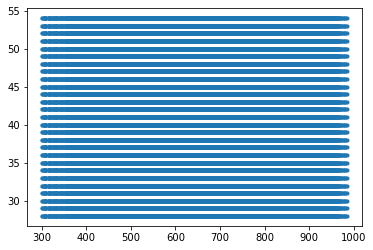

In [71]:
plt.plot(X1s, X2s, '.')
plt.show()

In [66]:
desired_outputs = np.zeros(len(X1s))
desired_outputs[df[]] = 1

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:


# _df = pd.DataFrame(dict(x1=df['ht_res_freqsplit'][100], x2=df['TC_RT_UDF_SET_Trim_UDF_QA_Fine'][100], y=[i for i in range(df.shape[0])]))
_df = pd.DataFrame(dict(x1=df['ht_res_freqsplit'][:100], x2=df['TC_RT_UDF_SET_Trim_UDF_QA_Fine'][:100], y=[i for i in range(100)]))
# df2 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=Ys))

# in_outlier = np.array(list(map(lambda el: 'outlier' if el=='red' else 'inlier', colors)))

fig = px.scatter_3d(_df, x='x1', y='x2', z='y')
# fig.add_scatter3d(x=df2['x1'], y=df2['x2'], z=df2['y'], name='FAPP')

# df3 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=f(X1s,X2s)))
# fig.add_scatter3d(x=df3['x1'], y=df3['x2'], z=df3['y'], name='ground_truth')
fig.update_traces(marker_size = 2)
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene=dict(aspectmode='cube')) #data
fig.show()

# Fuzzy Rule Base

## Import Fuzzy

### Input

In [6]:
class Input():
  observation_dim:int
  n_gen:int
  n_ind:int
  n_clone:int
  n_inf:int
  boundaries:List
  observations:list
  desired_outputs:List
  nr_rules:int
  THETA:int
  lm_prob: float
  lm_iter: int
  gamma_init: float


### Trapmf

In [7]:
def trapmf(x:np.array, abcd:list):
  """
  Trapezoidal membership function

  Parameters
  ----------
  x: 1d array
    Independent var
  abcd: 1d array, length 4
    [a, b, c, d] Breakpoints. Ensure a <= b <= c <= d.
  
  Returns
  -------
  y: 1d array
    Trapezoidal membership function
  """
  a, b, c, d = np.r_[abcd]

  y = np.zeros(len(x)) # 0 if x < a or d < x

  idx = np.nonzero(np.logical_and(a < x, x < b))[0] 
  y[idx] = (x[idx] - a) / float(b - a)

  idx = np.nonzero(np.logical_and(b <= x, x <=c))[0]
  y[idx] = 1

  idx = np.nonzero(np.logical_and(c < x, x < d))[0]
  y[idx] = (d - x[idx]) / float(d - c)

  return y

trapmf(np.array([1,2,2.5,6.7]), [1,3,6,10])

array([0.   , 0.5  , 0.75 , 0.825])

In [8]:
def antes(rule: np.ndarray) -> np.ndarray:
  """ Returns the antecedents of the rule system """
  return rule[:-1]

### w_min

In [9]:
def w_min(rule, observations):
  """
  W_min calculator

  Parameters
  ----------
  observations: nd array, size: (dim of input) x (number of input) 
    Observations

  Returns
  -------
  w: 1d array, size: number of inputs (observations)
    W_min for each input
  """
  obs = observations.T
  tmp = list(map(lambda ante, obs: trapmf(obs, ante), antes(rule), obs))
  return np.array(list(map(lambda out: min(out), np.array(tmp).T)))


### MamdaniInference

In [10]:
# MamdaniInference
def mamdaniInference(frbs:np.ndarray, observations):
  """
  We calculate the outputs as the formula above shows!
  Output membership functions
  Oservations, Rules => Outputs
  len(Outputs) will be the same as len(Observations)
  !!! Exception: Dividing by zero !!!
  """
  _observation_len = observations.shape[0]

  Ys = np.zeros(len(observations))
  _numerator = np.zeros(len(observations))
  _denumerator = np.zeros(len(observations))

  w_mins = np.empty((0, _observation_len), float)

  w_mins = np.array([np.vstack([w_mins, w_min(rule=rule, observations=observations)]) for rule in frbs])
  w_mins = np.reshape(w_mins, (frbs.shape[0], _observation_len))

  consequents_mtx = frbs[:,-1]

  A = np.array([consequents_mtx[:,0]]).T
  B = np.array([consequents_mtx[:,1]]).T
  C = np.array([consequents_mtx[:,2]]).T
  D = np.array([consequents_mtx[:,3]]).T

  _numerator_mtx = 3*w_mins * (D**2 - A**2) * (1-w_mins) + 3 * w_mins**2 * (C*D - A*B) + w_mins**3 * (C-D+A-B)*(C-D-A+B)
  _denominator_mtx = 2*w_mins * (D-A) + w_mins**2 * (C + A - D - B)

  _numerator = np.sum(_numerator_mtx, axis=0)
  _denominator = np.sum(_denominator_mtx, axis=0)
  Ys = np.divide(_numerator, _denominator, out=np.zeros_like(_numerator), where=_denominator!=0)
  Ys *= (1/3)
  return Ys


### Error (Canberra distance, L2)

In [11]:
def error_canberra(Ys, Ds):
  e = abs(Ys - Ds) / ( abs(Ys) + abs(Ds) )
  return np.sum(e)

def error_L2(Ys, Ds):
  e = Ys - Ds
  return np.linalg.norm(e)

def error(Ys, Ds):
  if METRIC_DISTANCE=='Canberra':
    return error_canberra(Ys, Ds)
  elif METRIC_DISTANCE=='L2':
    return error_L2(Ys, Ds)
  else:
    raise ValueError(f'[-] There is no such metric!(Available metrics: Canberra, L2)')

def __err__(frbs:np.ndarray, inp:Input):
  return error(Ys=mamdaniInference(frbs=frbs, observations=inp.observations), Ds=inp.desired_outputs)

In [12]:
print(error_L2(np.array([1,2,3]), np.array([2,3,3])))

1.4142135623730951


In [13]:
def error_canberra_piecewise(Ys, Ds):
  return abs(Ys - Ds) / ( abs(Ys) + abs(Ds) )

def error_L2_piecewise(Ys, Ds):
  return Ys-Ds

def error_piecewise(Ys, Ds):
  if METRIC_DISTANCE=='Canberra':
    return error_canberra_piecewise(Ys, Ds)
  elif METRIC_DISTANCE=='L2':
    return error_L2_piecewise(Ys, Ds)
  else:
    raise ValueError(f'[-] There is no such metric!(Available metrics: Canberra, L2)')


### Plot

In [14]:
def plot_trapmf(frbs, boundaries, obs=None):
  ''' Plotting Trapmf '''

  colors = ['green', 'orange', 'yellow', 'red']
  colors_obs = ['cyan', 'purple',  'magenta']

  nr_rules, nr_trapmf, _ = frbs.shape
  fig, ax = plt.subplots(nrows=nr_rules, ncols=nr_trapmf) # two axes on figure
  fig.set_figheight(5)
  fig.set_figwidth(20)

  # set the spacing between subplots
  fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
  
  X = []
  for b in boundaries:
    X.append(np.linspace(b[0],b[1],1000))

  for _rule_idx, _rule in enumerate(frbs):
    for _feature_idx, _trapmf in enumerate(_rule):
      y = trapmf(x=X[_feature_idx], abcd=_trapmf)
      ax[_rule_idx][_feature_idx].plot(X[_feature_idx], y, color=colors[_feature_idx%len(colors)])
      if obs.all() != None:
        if _feature_idx < nr_trapmf-1: 
          # antecedents
            for _obs_idx, _obs in enumerate(obs):
              mu = trapmf(x=np.array([_obs[_feature_idx]]), abcd=_trapmf)
              ax[_rule_idx][_feature_idx].vlines(x=_obs[_feature_idx], ymin=0, ymax=mu, color=colors_obs[_obs_idx%len(colors_obs)], linestyles='dashed')
              ax[_rule_idx][_feature_idx].hlines(y=mu, xmin=_obs[_feature_idx], xmax=boundaries[_feature_idx][1], color=colors_obs[_obs_idx%len(colors_obs)], linestyles='dashed')
              ax[_rule_idx][_feature_idx].set_title(f'Rule[{_rule_idx}], Ante[{_feature_idx}]')
        # consequent
        w = w_min(_rule, obs)
        a,b,c,d = _rule[-1][0], _rule[-1][1], _rule[-1][2], _rule[-1][3]
        colors_cons = [colors_obs[i%len(colors_obs)] for i in range(len(w))]
        labels_cons = [f'obs[{i}]' for i in range(len(w))]
        ax[_rule_idx][-1].hlines(y=w, xmin=(w * (b-a)+a), xmax=-1*(w*(d-c)-d), color=colors_cons, linestyles='dashed', label=labels_cons)
        ax[_rule_idx][-1].set_title(f'Rule[{_rule_idx}], Cons')


  # fig.legend((l1, l2), labels, 'upper left')
  fig.show()
  # fig.legend()

## Test



### Fuzzy

In [ ]:
frbs = np.array([[[1,2,2,3],[1,3,3,5],[3,4,4,5]], [[2,4,4,6],[1,2,2,3],[4,5.5,5.5,7]]])
boundaries = [[0,7], [0,7], [0,7]]
obs = np.array([[2.6,2.4]])
print(obs.T)
plot_trapmf(frbs, boundaries, obs=obs)
print(w_min(rule=frbs[0], observations=obs))
print(w_min(rule=frbs[1], observations=obs))

### Plot

In [ ]:
frbs = np.array( [
        [ [4, 6, 7, 8], [2, 6, 8, 9], [1, 7, 7, 9], [4, 4, 5, 8] ],
        [ [3, 6, 8, 10], [2, 7, 8, 10], [1, 8, 8, 10], [1, 4, 6, 10] ]
])

observations = []
observations.append([5,7.2,6])
observations.append([6,9,3.8])
observations.append([7,8,7.6])
observations = np.array(observations)
print(observations)
boundaries = [[3,9], [1,10], [-1, 9], [1,11]]

In [ ]:
plot_trapmf(frbs, obs=observations, boundaries=boundaries)

# Bacterial Evolutionary Algorithm

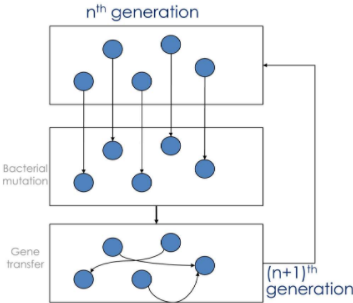

In [15]:
def generate_abcd(boundarie) -> tuple:
  """ Generates abcd values """
  bound = boundarie
  padding = PADDING_RATE * (bound[1] - bound[0])
  nums = np.random.uniform(low=bound[0] - padding, high=bound[1] + padding, size=4)
  nums.sort()
  return nums # a, b, c, d

In [16]:
def create_fuzzyRBS(inp:Input) -> np.ndarray:
  """ 
  Creates a random individum 
  Parameters:
  ------------
  observation_dim: int
    The dimension of the observations, we need that many antecedents in each rule
  boundaries: List[List]
    List of boundary. A boundary consists of a lower bound and an upper bound. (for all the antecedents and consequent) 
  
  """
  fuzzyRBS = np.ndarray((inp.nr_rules, inp.observation_dim+1, 4))
  for i in range(inp.nr_rules):
    for j in range(inp.observation_dim+1):
      fuzzyRBS[i][j] = generate_abcd(boundarie=inp.boundaries[j])
  return fuzzyRBS


In [17]:
def set_gene(frbs:np.ndarray, geneIdx:int, newGene:np.array):
  r, c, _ = frbs.shape
  frbs[geneIdx//c][geneIdx % c] = newGene

In [18]:
def geneTransfer(donor:np.ndarray, acceptor:np.ndarray, geneIds:np.array):
  """ Donor and acceptor has the same shape """
  r, c, _ = donor.shape
  for geneIdx in geneIds:
    acceptor[geneIdx//c][geneIdx % c] = np.copy(donor[geneIdx//c][geneIdx % c])

In [19]:
def mutate_gene(frbs:np.ndarray, geneIdx:int, boundaries:np.array):
  r, c, _ = frbs.shape
  frbs[geneIdx//c][geneIdx % c] = generate_abcd(boundarie=boundaries[geneIdx % c])

def mutate_genes(frbs:np.ndarray, geneIds:int, boundaries:np.array):
  for id in geneIds:
    mutate_gene(frbs, id, boundaries)

In [20]:
def get_rnd_geneId_lists(gene_nr):
  tmp=np.arange(gene_nr)
  rnd.shuffle(tmp)
  tmp = np.array_split(tmp, rnd.randint(2, gene_nr))
  return tmp

print(get_rnd_geneId_lists(20))

[array([17,  2]), array([19,  3]), array([5]), array([14]), array([1]), array([8]), array([15]), array([18]), array([12]), array([11]), array([0]), array([16]), array([6]), array([10]), array([13]), array([9]), array([7]), array([4])]


### Bacterial Mutation

In [21]:
def bacterialMutation(population: List[np.ndarray], clones:List[np.ndarray], inp:Input):
  r, c, _ = population[0].shape # The number of genes in the choromosome (r*c)
  for idx in range(inp.n_ind):
    for c_idx in range(inp.n_clone):
      clones[c_idx] = np.copy(population[idx])
    # print('clones-err: ', [  __err__(clone, inp) for clone in clones])

    for genes in get_rnd_geneId_lists(r*c):
      for c_idx in range(1, inp.n_clone):
        mutate_genes(frbs=clones[c_idx], geneIds=genes, boundaries=inp.boundaries)
        # mutate_gene(frbs=clones[c_idx], geneIdx=i, boundaries=inp.boundaries)
      # print('pre-clones-err: ', [  __err__(clone, inp) for clone in clones])
      clones[0] = np.copy(min(clones, key=lambda clone: __err__(clone, inp)))
      for c_idx in range(inp.n_clone):
        if (clones[c_idx] != clones[0]).all():
          geneTransfer(donor=clones[0], acceptor=clones[c_idx], geneIds=genes)
    
    population[idx] = np.copy(min(clones, key=lambda clone: __err__(clone, inp)))
    

### Gene Transfer

In [22]:
def bacterialGeneTransfer(population: List[np.ndarray], inp:Input):
  r, c, _ = population[0].shape

  for i in range(inp.n_inf):
    population.sort(key=lambda indiv: __err__(indiv, inp))
    donorId = rnd.choice(range(inp.n_ind//2))
    acceptorId = rnd.choice(range(inp.n_ind//2, inp.n_ind))
    geneIds = random.sample(range(r*c), 2)
    geneTransfer(donor=population[donorId], acceptor=population[acceptorId], geneIds=geneIds)
  pass

### Bacterial Evolution

In [23]:
from tqdm import trange

def bacterialEvoulution(inp:Input) -> np.ndarray:
  population = [create_fuzzyRBS(inp) for _ in range(inp.n_ind)]
  clones = [create_fuzzyRBS(inp) for _ in range(inp.n_clone)]

  for ep in trange(inp.n_gen):
    bacterialMutation(population, clones, inp)
    bacterialGeneTransfer(population, inp)
    population.sort(key=lambda indiv: __err__(indiv, inp))
    print('best-err: ', __err__(min(population, key=lambda indiv: __err__(indiv, inp)), inp))
  return population[0]

# Test

In [ ]:
boundaries = [[300, 1000], [25, 55], [300, 1000]]

inp2 = Input()
inp2.n_gen = 3
inp2.n_ind = 5
inp2.n_clone = 5
inp2.n_inf = 5
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 2

best_indiv = bacterialEvoulution(inp2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

# Outlier detection

In [25]:
def create_outlier_list(Ys, Ds, theta):
  e = (error_canberra_piecewise(Ys,Ds)>=theta)
  return e, np.count_nonzero(e)

In [26]:
FuzzyRuleBase = {}
ErrorMatrix = {}
OutlierList = {}
OutlierArray = {}
AverageErrors = {}
optRule = 0

THETA = 0.1

def outlierDetection(minRule, maxRule, nRuns, inp:Input):
  for rule in range(minRule, maxRule+1):
    inp.nr_rules=rule
    FuzzyRuleBase[rule] = {}
    ErrorMatrix[rule] = {}
    OutlierArray[rule] = {}
    for run in range(1, nRuns+1):
      FuzzyRuleBase[rule][run] = bacterialEvoulution(inp)
      Ys=mamdaniInference(frbs=FuzzyRuleBase[rule][run], inp=inp)
      ErrorMatrix[rule][run] = error_canberra(Ys=Ys, Ds=inp.desired_outputs)
      OutlierList, OutlierSum = create_outlier_list(Ys=Ys, Ds=inp.desired_outputs, theta=THETA)
      print(f'OutlierList: {OutlierList} , OutlierSum: {OutlierSum}')
      OutlierArray[rule][run] = OutlierList

    sum_ErrorMatrix = 0
    for i in range(1, nRuns+1):
      sum_ErrorMatrix += ErrorMatrix[rule][i]
    AverageErrors[rule] = (1/nRuns) * sum_ErrorMatrix

  ErrorDrop = AverageErrors[minRule] - AverageErrors[minRule+1]
  maxErrorDrop = ErrorDrop
  optRule = minRule
  for rule in range(minRule+1, maxRule):
    ErrorDrop = AverageErrors[rule] - AverageErrors[rule+1]
    # print(f'Rule: {rule} - ErrorDrop:  {ErrorDrop}')
    if ErrorDrop > maxErrorDrop:
      maxErrorDrop = ErrorDrop
      optRule = rule
  OutlierList = OutlierArray[optRule][1]
  for run in range(2, nRuns+1):
    OutlierList = np.array(OutlierList)&np.array(OutlierArray[optRule][run])
  # print('OutlierList:', OutlierList)
  # print('optRule: ', optRule)
  return OutlierList, FuzzyRuleBase

### Test

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
inp = Input()
inp.n_gen = 50
inp.n_ind = 20
inp.n_clone = 10
inp.n_inf = 10
inp.boundaries = np.array(boundaries)
inp.observations = np.array(observations)
inp.observation_dim = inp.observations.shape[1]
inp.desired_outputs = np.array(desired_outputs)
inp.nr_rules = 0

minRule, maxRule, nRuns = (2, 5, 3)
ol, frb = outlierDetection(minRule,maxRule,nRuns, inp)
print(FuzzyRuleBase, '\n', ErrorMatrix)

In [ ]:
def plot_FAPPs(frbs, X1s, X2s, inp:Input):
  for rule in range(minRule, maxRule+1):
    fig = plt.figure(figsize=(15,15))
    ax = plt.axes(projection='3d')

    ax.scatter(X1s, X2s, inp.desired_outputs, label=f'input_data')
    for i in range(1,4):
      Ys = mamdaniInference(frbs = frbs[rule][i], inp=inp)
      ax.scatter(X1s, X2s, Ys, label=f'run: {i}')
    # ax.view_init(10, 25)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    ax.legend()
    ax.set_title(f'Rule_nr: {rule}')

In [ ]:

plot_FAPPs(FuzzyRuleBase, X1s, X2s, inp)

In [ ]:
outlierList = create_outlier_list(Ys=mamdaniInference(FuzzyRuleBase[4][1], inp=inp), Ds=inp.desired_outputs, theta=THETA) 

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = FuzzyRuleBase[4][1], inp=inp)

colors = np.array(list(map(lambda el: 'red' if el==True else 'green', ol)))

ax.scatter(X1s, X2s, desired_outputs, c=colors)
# ax.scatter(X1s, X2s, Ys  )
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
import matplotlib.pyplot as plt

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s)
desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))
print(observations[0])

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 100
inp2.n_ind = 30
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 2
inp2.THETA = 0.1

best_indiv = bacterialEvoulution(inp2)

# Supervised Learning (in/outlier) - Test

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 50
inp2.n_ind = 15
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 8

# best_indiv = bacterialEvoulution(inp2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, inp=inp2)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)

test_data = f(X1s, X2s) + rnd.normal(0,0.4, 100)
test_data[25] = 4
test_data[79] = 23
test_data[80] = 23.1
test_data[81] = 23.18
# test_data = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34])
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59])
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1])

plt.plot(test_data, '.b')

observations = list(zip(X1s, X2s))

In [ ]:

fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# inp2.desired_outputs = test_data
inp3 = copy.deepcopy(inp2)
inp3.desired_outputs = test_data
Ys = mamdaniInference(frbs = best_indiv, inp=inp3)

THETA=0.1
ol = create_outlier_list(Ys=test_data, Ds=Ys, theta=THETA)[0]

colors = np.array(list(map(lambda el: 'red' if el==True else 'green', ol)))

ax.scatter(X1s, X2s, test_data, color=colors)
ax.scatter(X1s, X2s, Ys, color='cyan')

# arbitrary point
inp3 = copy.deepcopy(inp2)
x1 = 5
x2 = 6
des_out = 10
inp3.observations = np.array([[x1,x2]])
inp3.desired_outputs = np.array([des_out])
y = mamdaniInference(frbs = best_indiv, inp=inp3)
print('y:', y)
ax.scatter(x1,x2,y,color='magenta' if create_outlier_list(Ys=np.array([des_out]), Ds=y, theta=THETA)[0] else 'black')
# ax.view_init(10, 25)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import pandas as pd

df = pd.DataFrame(dict(x1=X1s, x2=X2s, y=test_data))
df2 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=Ys))

in_outlier = np.array(list(map(lambda el: 'outlier' if el=='red' else 'inlier', colors)))

fig = px.scatter_3d(df, x='x1', y='x2', z='y', color=in_outlier)
fig.add_scatter3d(x=df2['x1'], y=df2['x2'], z=df2['y'], name='FAPP')

df3 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=f(X1s,X2s)))
fig.add_scatter3d(x=df3['x1'], y=df3['x2'], z=df3['y'], name='ground_truth')
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene=dict(aspectmode='cube')) #data
fig.show()

# Levenberg–Marquardt

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 10
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2
inp1.lm_prob = 1
inp1.lm_iter = 25
inp1.gamma_init = 7

test_frbs = bacterialEvoulution(inp1)

In [ ]:
print(error(Ys=mamdaniInference(test_frbs, inp1.observations), Ds=inp1.desired_outputs))

In [ ]:
frbs = np.array( [
        [ [4, 6, 7, 8], [2, 6, 8, 9], [1, 7, 7, 9], [4, 4, 5, 8] ],
        [ [3, 6, 8, 10], [2, 7, 8, 10], [1, 8, 8, 10], [1, 4, 6, 10] ]
])

observations = []
observations.append([5,7.2,6])
observations.append([6,9,3.8])
observations.append([7,8,7.6])
observations = np.array(observations)
desired_outputs = np.array([3,5,7])
boundaries = [[3,9], [1,10], [-1, 9], [4,8]]

In [ ]:
frbs.shape

In [ ]:
test_frbs.shape

### Jacobian matrix

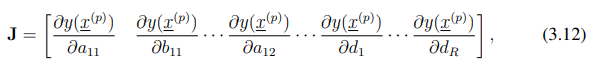

In [ ]:
def N_ij(start, end, x):
  # WARN: include/exclude boundaries
  return 1 if x >= start and x <= end else 0

In [ ]:
def get_N_S(bact, X):
  ''' Returns the N (numerator) and S (denominator) values'''

  N, S = 0,0
  # for x_p in X:
  #   # -- getting F,G,N,S -- #
  #   for r_idx, rule in enumerate(bact):
  #     # w - is w_min
  #     w = w_min(rule, np.array([x_p]))[0]

  #     #a,b,c,d of the consequent
  #     a, b, c, d = rule[-1][0], rule[-1][1], rule[-1][2], rule[-1][3]

  #     _numerator = 3*w * (d**2 - a**2) * (1-w) + 3 * w**2 * (c*d - a*b) + w**3 * (c-d+a-b)*(c-d-a+b)
  #     _denominator = 2*w * (d-a) + w**2 * (c + a - d - b)

  #     N += _numerator
  #     S += _denominator
  #   # -- F,G,N,S -- #
  

  _observation_len = X.shape[0]

  Ys = np.zeros(len(X))
  _numerator = np.zeros(len(X))
  _denumerator = np.zeros(len(X))

  w_mins = np.empty((0, _observation_len), float)

  w_mins = np.array([np.vstack([w_mins, w_min(rule=rule, observations=X)]) for rule in bact])
  w_mins = np.reshape(w_mins, (bact.shape[0], _observation_len))

  consequents_mtx = bact[:,-1]

  A = np.array([consequents_mtx[:,0]]).T
  B = np.array([consequents_mtx[:,1]]).T
  C = np.array([consequents_mtx[:,2]]).T
  D = np.array([consequents_mtx[:,3]]).T

  _numerator_mtx = 3*w_mins * (D**2 - A**2) * (1-w_mins) + 3 * w_mins**2 * (C*D - A*B) + w_mins**3 * (C-D+A-B)*(C-D-A+B)
  _denominator_mtx = 2*w_mins * (D-A) + w_mins**2 * (C + A - D - B)

  N = np.sum(_numerator_mtx)
  S = np.sum(_denominator_mtx)

  # print(f'N={N}, S={S}')
  return N, S

In [ ]:
from numpy.core.fromnumeric import shape
def JacobianMtx(bact, X):
  '''
  Jacobi matrix

  Parameters:
  --------
    param: bact - frbs
    param: X - observations
  '''
  nr_rules, nr_trapmf, _ = bact.shape 
  R = nr_rules
  n = nr_trapmf-1 # nr of antecedents / dim. of the observation
  J = np.empty((len(X), 4*(n+1)*R))
  J_row, J_col = 0, 0
  F = []
  G = []

  N, S = get_N_S(bact, X)

  for x_p in X:
    for i, rule in enumerate(bact):
      # w - is w_min
      W = w_min(rule, np.array([x_p]))

      ''' CONSEQUENT's attributes '''
      A, B, C, D = rule[-1][0], rule[-1][1], rule[-1][2], rule[-1][3]

      dF_dW = 3*(D**2-A**2)*(1-2*W) + 6*W*(C*D-A*B) + 3*W**2*((C-D)**2 - (A-B)**2)
      dG_dW = 2**(D-A) + 2*W*(C+A-D-B)

      if N == 0:
        dy_dW = 0
      else:          
        dy_dW = (1/3) * (N*dF_dW - S*dG_dW) / N**2

      '''Antecedents'''
      for j in range(n): # iterate through the ANTECEDENTS
        trap = rule[j]
        a,b,c,d = trap[0], trap[1], trap[2], trap[3]
        x = x_p[j]

        dmu_da = (x-b) / (b-a)**2 * N_ij(a,b,x)
        dmu_db = (a-x) / (b-a)**2 * N_ij(a,b,x)
        dmu_dc = (d-x) / (d-c)**2 * N_ij(c,d,x)
        dmu_dd = (x-c) / (d-c)**2 * N_ij(c,d,x)
      
        dW_dmu = 1 if trapmf(np.array([x]), abcd=trap) == W else 0

        dy_da = dy_dW*dW_dmu*dmu_da
        dy_db = dy_dW*dW_dmu*dmu_db
        dy_dc = dy_dW*dW_dmu*dmu_dc
        dy_dd = dy_dW*dW_dmu*dmu_dd

        J[J_row][J_col] = dy_da
        J_col = J_col+1
        J[J_row][J_col] = dy_db
        J_col = J_col+1
        J[J_row][J_col] = dy_dc
        J_col = J_col+1
        J[J_row][J_col] = dy_dd
        J_col = J_col+1

      '''Consequent'''
      dt_F_A = -6*W*A + 6*W**2*A - 3*W**2*B - 2*W**3*(A-B)
      dt_F_B = -3*W**2*A + 2*W**3*(A-B)
      dt_F_C = 3*W**2*D - 2*W**3*(D-C)
      dt_F_D = 6*W*D - 6*W**2*D + 3*W**2*C + 2*W**3*(D-C)

      dt_G_A = -2*W + W**2
      dt_G_B = -W**2
      dt_G_C = W**2
      dt_G_D = 2*W - W**2

      if N == 0:
        dy_dA=0
        dy_dB=0
        dy_dC=0
        dy_dD=0
      else:
        dy_dA = (1/3) * (N*dt_F_A - S*dt_G_A) / N**2
        dy_dB = (1/3) * (N*dt_F_B - S*dt_G_B) / N**2
        dy_dC = (1/3) * (N*dt_F_C - S*dt_G_C) / N**2
        dy_dD = (1/3) * (N*dt_F_D - S*dt_G_D) / N**2

      J[J_row][J_col] = dy_dA
      J_col = J_col+1
      J[J_row][J_col] = dy_dB
      J_col = J_col+1
      J[J_row][J_col] = dy_dC
      J_col = J_col+1
      J[J_row][J_col] = dy_dD
      J_col = J_col+1

    J_row = J_row+1
    J_col = 0
  return J


In [ ]:
%timeit JacobianMtx(bact=test_frbs, X=inp1.observations)
# J2 = JacobianMtx(bact=test_frbs, X=inp1.observations)
# print(J2.shape)
# print(J2)


In [ ]:
# J = JacobianMtx(bact=frbs, X=observations)
# print(J.shape)
# print(J)
%timeit JacobianMtx(bact=test_frbs, X=inp1.observations)


In [ ]:
a = np.array([[1,0],[0,1]])
b = np.array([[4,5],[3,2]])
print(a, '\n\n' , b,'\n\n', a*b, '\n\n',  np.matmul(a,b))


In [ ]:
J = JacobianMtx(bact=frbs, X=observations)
A = np.matmul(J.T, J)
print(A.shape)

### L-M

#### Update vector

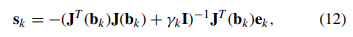

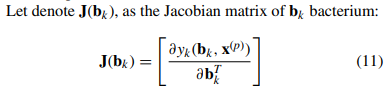

In [ ]:
def update_vector(b, X, e, γ):
  '''
    Returns: update vector - s

    Parameters:
    -------
    param b: bacterium
    param X: observations
    param e: errors (vector) - piecewise
    param γ: bravery factor
  '''
  # print('JacobianMtx')
  J = JacobianMtx(bact=b, X=X)
  # print(J)
  r,c = J.shape
  I = np.eye(c)
  # print('mamdaniInference')
  Ys = mamdaniInference(frbs=b, observations=X)
  # print('return')
  return -inv((J.T @ J + γ*I)) @ J.T @ e

In [ ]:
# e = error_piecewise(Ys=mamdaniInference(frbs=test_frbs, observations=inp1.observations), Ds=inp1.desired_outputs) 
# s = update_vector(b=test_frbs, X=observations, e=e, γ=2)
# print(s, s.shape)

#### Trust region

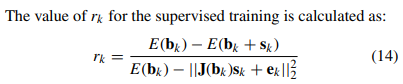

In [ ]:
def trust_region(b, X, Ds, s, e):
  '''
    Returns: trust region - r

    Parameters:
    ---------
    param b: bacterium-frbs
    param s: update vector

  '''
  E_b = error(Ys=mamdaniInference(frbs=b, observations=X), Ds=Ds)
  E_bs = error(Ys=mamdaniInference(frbs=b+s.reshape(b.shape), observations=X), Ds=Ds)
  s.ravel()
  return (E_b - E_bs) / (E_b - linalg.norm(JacobianMtx(bact=b, X=X) @ s + e))

In [ ]:
# print(trust_region(b=frbs, X=observations, Ds=desired_outputs, s=s, e=e))

#### Bravery factor

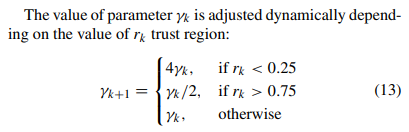

In [ ]:
def bravery_factor(gamma, r):
  # bravery_factor
  # gamma
  if r < 0.25:
    return 4*gamma
  elif r > 0.75:
    return gamma/2
  else:
    return gamma

#### Evaluation

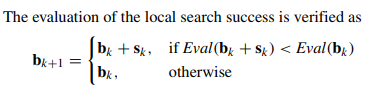

In [ ]:
def evaluation(b, s, X, Ds):
  s = s.reshape(b.shape)
  Ys_bs = mamdaniInference(frbs=b+s, observations=X)
  Ys_b = mamdaniInference(frbs=b, observations=X)
  # print(error(Ys=Ys_bs, Ds=Ds), error(Ys=Ys_b, Ds=Ds))
  if error(Ys=Ys_bs, Ds=Ds) < error(Ys=Ys_b, Ds=Ds):
    return b+s
  else:
    return b

#### Stopping criteria

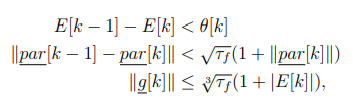

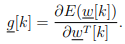

In [ ]:
def gradient_vector(J, e):
  r, c = J.shape
  gradVect = np.zeros(c)
  for j in range(c):
    gradVect[j] = 0
    for k in  range(r):
      gradVect[j] += 2*e[k]*J[k][j]
  return gradVect

In [ ]:
J=JacobianMtx(bact=test_frbs, X=inp1.observations)
# print(J.shape)
gradVect = gradient_vector(J=J,e=error_piecewise(Ys=mamdaniInference(frbs=test_frbs, observations=inp1.observations), Ds=inp1.desired_outputs))
print(norm(gradVect))

In [ ]:
def stopping_crit_reached(k, E_old, E_new, s, b, J, e, inp:Input):
  # at least 2 steps are required in order to stop
  if k <= 1:
    return False
  τ = 0.0001
  g = gradient_vector(J, e)
  # print(f'1st:{E_old - E_new < τ * (1+E_new)}')
  # print(f'2st:{norm(s) < np.sqrt(τ)*(1+norm(b))}')
  # print(f'3st:{norm(g) <= np.cbrt(τ)*(1+abs(E_new))}')
  if E_old - E_new < τ * (1+E_new) and \
      norm(s) < np.sqrt(τ)*(1+norm(b)) and \
      norm(g) <= np.cbrt(τ)*(1+abs(E_new)):
    return True
  return False

#### Main L-M

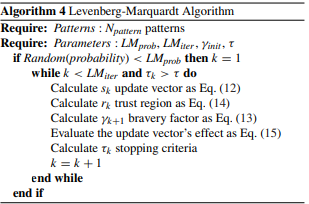

In [ ]:
def LevenbergMarquardt(b, inp:Input):
  # print(f'start-Error: {error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)}')
  if rnd.rand() < inp.lm_prob:
    k=0
    E_old, E_new = 0, 0
    gamma = inp.gamma_init
    s, J, e = None,None,None
    while k < inp.lm_iter and not stopping_crit_reached(k=k, E_old=E_old, E_new=E_new, s=s, b=b, J=J, e=e, inp=inp):
      # print('k=',k)
      e = error_piecewise(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      E_old = E_new
      E_new = error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      # print('update_vector')
      s = update_vector(b=b, X=inp.observations, e=e, γ=gamma)
      # print('trust_region')
      r = trust_region(b=b, X=inp.observations, Ds=inp.desired_outputs, s=s, e=e)
      # print("bravery")
      gamma = bravery_factor(gamma, r)
      # print('evolution')
      
      b = evaluation(b=b,s=s,X=inp.observations,Ds=inp.desired_outputs)
      # for the next stopping_crit
      J = JacobianMtx(bact=b, X=inp1.observations)
      e = error_piecewise(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)
      # print('next_iter')
      
      k = k+1
  # print(f'end-Error: {error(Ys=mamdaniInference(frbs=b, observations=inp.observations), Ds=inp.desired_outputs)}')
  return b

## Test L-M

In [ ]:
best_frbs = LevenbergMarquardt(b=test_frbs, inp=inp1)

In [ ]:
print(__err__(test_frbs, inp1))
print(__err__(best_frbs, inp1))

# Bacterial Memetic Algorithm

### Bacterial Memetic Evolution

In [ ]:
def LevenbergMarquardtOnPopulation(population, inp):
  for indiv_idx in range(len(population)):
    population[indiv_idx] = LevenbergMarquardt(b=population[indiv_idx], inp=inp)


In [ ]:
def bacterialMemeticEvoulution(inp:Input) -> np.ndarray:
  population = [create_fuzzyRBS(inp) for _ in range(inp.n_ind)]
  clones = [create_fuzzyRBS(inp) for _ in range(inp.n_clone)]

  for ep in trange(inp.n_gen):
    bacterialMutation(population, clones, inp)
    LevenbergMarquardtOnPopulation(population, inp)
    bacterialGeneTransfer(population, inp)
    population.sort(key=lambda indiv: __err__(indiv, inp))
    print('best-err: ', __err__(min(population, key=lambda indiv: __err__(indiv, inp)), inp))
  return population[0]

## Test

### Test1

In [ ]:
inp1 = Input()
inp1.n_gen = 10
inp1.n_ind= 2
inp1.n_clone= 3
inp1.n_inf= 10
inp1.boundaries = np.array([[0,9],[1,10],[2,8]])
inp1.observations= np.array([[2,6], [3,5.5], [2.2,5.3]])
inp1.observation_dim = inp1.observations.shape[1]
inp1.desired_outputs= np.array([2.5, 3, 4])
inp1.nr_rules= 2
inp1.lm_prob = 1
inp1.lm_iter = 25
inp1.gamma_init = 0.5

test_frbs = bacterialMemeticEvoulution(inp1)

### TEST: BEA (L-M applied at the end)

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 5
inp2.n_ind = 15
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 8
# inp2.nr_rules= 2
inp2.lm_prob = 1
inp2.lm_iter = 25
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

#### LM

Applying LM

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')


best_indiv = LevenbergMarquardt(best_indiv, inp=inp2)
Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

LM - applied again

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')


best_indiv = LevenbergMarquardt(best_indiv, inp=inp2)
Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

### TEST: (in plane) BMA

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

X1s = np.linspace(5, 15, 100)
X2s = np.linspace(2, 9, 100)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 100)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 50
inp2.n_ind = 10
inp2.n_clone = 10
inp2.n_inf = 10
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 12
# inp2.nr_rules= 2
inp2.lm_prob = 0.1
inp2.lm_iter = 25
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

### TEST: (meshgrid) BMA

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

x1s = np.linspace(5, 15, 100)
x2s = np.linspace(2, 9, 100)

X1s, X2s = np.meshgrid(x1s,x2s)
X1s = np.ravel(X1s)
X2s = np.ravel(X2s)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 10000)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

x1s = np.linspace(5, 15, 15)
x2s = np.linspace(2, 9, 15)

X1s, X2s = np.meshgrid(x1s,x2s)
X1s = np.ravel(X1s)
X2s = np.ravel(X2s)


def f(x1, x2):
  return np.sin(x1) + 2*x2


desired_outputs = f(X1s, X2s) + rnd.normal(0,0.4, 255)
# desired_outputs = np.insert(desired_outputs, [25,26,27,79,80,82], [4,4.1,4.2,22,22.3, 22.34]) 
# X1s = np.insert(X1s, [25,26,27,79,80,82], [10, 10.1, 10.2, 5,5.5, 5.59]) 
# X2s = np.insert(X2s, [25,26,27,79,80,82], [2,2.1,2.2, 6,6.01,6.1]) 

plt.plot(desired_outputs, '.b')

observations = list(zip(X1s, X2s))

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs)
# ax.scatter(X1s, X2s, Ys)
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')

In [ ]:
boundaries = [[5, 15], [2, 9], [-10, 30]]

inp2 = Input()
inp2.n_gen = 10
inp2.n_ind = 5
inp2.n_clone = 5
inp2.n_inf = 5
inp2.boundaries = np.array(boundaries)
inp2.observations = np.array(observations)
inp2.observation_dim = inp2.observations.shape[1]
inp2.desired_outputs = np.array(desired_outputs)
inp2.nr_rules = 5
# inp2.nr_rules= 2
inp2.lm_prob = 0.1
inp2.lm_iter = 7
inp2.gamma_init = 0.5

In [ ]:
best_indiv = bacterialMemeticEvoulution(inp2)

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

Ys = mamdaniInference(frbs = best_indiv, observations=inp2.observations)

ax.scatter(X1s, X2s, desired_outputs, label='training_data')
ax.scatter(X1s, X2s, Ys, label='FRBS')
# ax.view_init(10, 25)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
ax.legend()

In [ ]:
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import pandas as pd

df = pd.DataFrame(dict(x1=X1s, x2=X2s, y=desired_outputs))
df2 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=Ys))

# in_outlier = np.array(list(map(lambda el: 'outlier' if el=='red' else 'inlier', colors)))

fig = px.scatter_3d(df, x='x1', y='x2', z='y')
fig.add_scatter3d(x=df2['x1'], y=df2['x2'], z=df2['y'], name='FAPP')

df3 = pd.DataFrame(dict(x1=X1s, x2=X2s, y=f(X1s,X2s)))
fig.add_scatter3d(x=df3['x1'], y=df3['x2'], z=df3['y'], name='ground_truth')
fig.update_traces(marker_size = 2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),scene=dict(aspectmode='cube')) #data
fig.show()

# Tasks:

 l-m, bma-parall,  sub-sampl, rule-reduce, autoenc, defuzz-other